In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
project_path='/content/drive/My Drive/Capstone_Project/Data'
os.chdir(project_path)

In [3]:
project_path

'/content/drive/My Drive/Capstone_Project/Data'

In [4]:
!pwd

/content/drive/My Drive/Capstone_Project/Data


In [5]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 MetaData_information.csv	        stage_2_train_images
 stage_2_detailed_class_info.csv        stage_2_train_labels.csv
 stage_2_sample_submission.csv


### Extracting the information from the given csv file

In [0]:
import pandas as pd
dataframe1=pd.read_csv("stage_2_detailed_class_info.csv")
dataframe2=pd.read_csv("stage_2_train_labels.csv")

In [7]:
dataframe1.set_index("patientId", inplace = True)
dataframe2.set_index("patientId", inplace = True)
combined_df = pd.concat([dataframe1, dataframe2], axis=1, join='inner')
combined_df.reset_index(inplace=True)
combined_df

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1


In [0]:
combined_df = combined_df.drop(['x','y','width', 'height'], axis = 1).copy()

In [9]:
combined_df.head()

,patientId,class,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1


In [10]:
combined_df = combined_df.drop_duplicates()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
 2   Target     26684 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 833.9+ KB


### Making the data ready for training the model

In [0]:
import numpy as np
Training_Data_Image = []

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

In [0]:
project_path = '/content/drive/My Drive/Capstone_Project/Data/stage_2_train_images'
os.chdir(project_path)
images_path = os.listdir(project_path)

In [0]:
!pip install pydicom
import pydicom

In [0]:
for n, image in enumerate(images_path):
        ds = pydicom.dcmread(os.path.join(project_path, image))
        ds_new=ds.pixel_array
        img = cv2.resize(ds_new, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)   
        img2 = cv2.merge((img,img,img))
        #print(img.shape)  
        Training_Data_Image.append(img2)
        if n % 200 == 0:
          print('{} image information extracted'.format(n))

In [0]:
np.save(os.path.join('/content/drive/My Drive/Capstone_Project', 'train_data_set_1'), Training_Data_Image)

In [0]:
import os
project_path='/content/drive/My Drive/Capstone_Project/'
os.chdir('/content/drive/My Drive/Capstone_Project')

In [0]:
import numpy as np
training_data=np.load('train_data_set_1.npy', allow_pickle=True)

In [17]:
training_data.shape

(26684, 224, 224, 3)

### Target labels.

In [0]:
y_target=[]
images=[]
for n, image in enumerate(images_path):
        head, sep, tail = image.partition('.')
        new=combined_df[combined_df['patientId']==str(head)]
        y_target.append(new['Target'].values[0])
        images.append(image)

In [19]:
len(y_target)

26684

### Class Labels

In [0]:
combined_df['class'] = combined_df['class'].map({'No Lung Opacity / Not Normal': 0, 'Normal': 1, 'Lung Opacity':2})

In [0]:
y_class=[]
images=[]
for n, image in enumerate(images_path):
        head, sep, tail = image.partition('.')
        new=combined_df[combined_df['patientId']==str(head)]
        y_class.append(new['class'].values[0])
        images.append(image)

In [22]:
len(y_class)

26684

### Splitting the data into training and validation dataset

In [23]:
training_data.shape

(26684, 224, 224, 3)

In [24]:
training_data[0].shape

(224, 224, 3)

In [0]:
Training_X=training_data[0:18679]
Validating_X=training_data[18679:]

In [0]:
import numpy as np
Training_y_target=y_target[0:18679]
Validating_y_target=y_target[18679:]
Training_y_target = np.array(Training_y_target)
Validating_y_target = np.array(Validating_y_target)

In [27]:
from keras.utils import to_categorical
Training_y_class=y_class[0:18679]
Validating_y_class=y_class[18679:]
Training_y_class= np.array(Training_y_class)
Validating_y_class= np.array(Validating_y_class)
Training_y_class_new = to_categorical(Training_y_class,num_classes=3)
Validating_y_class_new = to_categorical(Validating_y_class,num_classes=3)

Using TensorFlow backend.


### Model 1: Resnet50 with Target

In [0]:
import tensorflow as tf

In [29]:
# example of loading the resnet50 model
from keras.applications.resnet50 import ResNet50
# load model
tf.keras.backend.clear_session()
model = ResNet50()
# summarize the model
model.summary()

102858752/102853048 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [0]:
tf.keras.backend.clear_session()

In [31]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [32]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
#input_shape=(224,224,3)
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 75,020,769
Trainable params: 51,433,057
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
history = model.fit(Training_X, Training_y_target, epochs=15, batch_size=100, validation_data=(Validating_X, Validating_y_target), verbose=1)

Train on 18679 samples, validate on 8005 samples
Epoch 1/15
18679/18679 [==============================] - 85s 5ms/step - loss: 0.4168 - accuracy: 0.8015 - val_loss: 1.5482 - val_accuracy: 0.7347
Epoch 2/15
18679/18679 [==============================] - 76s 4ms/step - loss: 0.3120 - accuracy: 0.8565 - val_loss: 2.1873 - val_accuracy: 0.7347
Epoch 3/15
18679/18679 [==============================] - 76s 4ms/step - loss: 0.2024 - accuracy: 0.9154 - val_loss: 3.0789 - val_accuracy: 0.7347
Epoch 4/15
18679/18679 [==============================] - 76s 4ms/step - loss: 0.1202 - accuracy: 0.9553 - val_loss: 2.6050 - val_accuracy: 0.7348
Epoch 5/15
18679/18679 [==============================] - 76s 4ms/step - loss: 0.0603 - accuracy: 0.9821 - val_loss: 4.4171 - val_accuracy: 0.7347
Epoch 6/15
18679/18679 [==============================] - 76s 4ms/step - loss: 0.0323 - accuracy: 0.9911 - val_loss: 4.9398 - val_accuracy: 0.7347
Epoch 7/15
18679/18679 [==============================] - 76s 4ms/ste

In [0]:
y_predict = model.predict_classes(Validating_X)

In [35]:
# Accuracy Report
from sklearn import metrics
Confusion_Matrix=(metrics.confusion_matrix(Validating_y_target,y_predict))
print('Confusion Matrix')
print(Confusion_Matrix)

Confusion Matrix
[[5881    0]
 [2124    0]]


In [36]:
from sklearn.metrics import classification_report 
print('Classification Report for each class level metrics : ')
print(classification_report(Validating_y_target,y_predict))

Classification Report for each class level metrics : 
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5881
           1       0.00      0.00      0.00      2124

    accuracy                           0.73      8005
   macro avg       0.37      0.50      0.42      8005
weighted avg       0.54      0.73      0.62      8005



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print('Accuracy :', accuracy_score(Validating_y_target,y_predict))
print('Recall :', recall_score(Validating_y_target,y_predict, average='macro')) 
print('Precision :', precision_score(Validating_y_target,y_predict, average='macro'))
print('F1 Score :', f1_score(Validating_y_target,y_predict, average='macro'))

Accuracy : 0.7346658338538413
Recall : 0.5
Precision : 0.36733291692692066
F1 Score : 0.4235200921791733


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# Function Defined to plot Accuracy 
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, test_acc, label='Testing Accuracy')
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.legend()
  plt.figure()

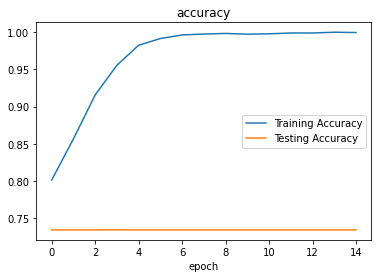

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
plot_accuracy(history)

### Model 1: Resnet50 with class

In [0]:
tf.keras.backend.clear_session()

In [42]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [43]:
model = Sequential()
model.add(restnet)
model.add(Dense(512, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 75,020,791
Trainable params: 51,433,079
Non-trainable params: 23,587,712
_________________________________________________________________


In [44]:
history = model.fit(Training_X, Training_y_class_new, epochs=15, batch_size=100, validation_data=(Validating_X, Validating_y_class_new), verbose=1)

Train on 18679 samples, validate on 8005 samples
Epoch 1/15
18679/18679 [==============================] - 79s 4ms/step - loss: 0.7927 - accuracy: 0.6239 - val_loss: 1.7570 - val_accuracy: 0.3829
Epoch 2/15
18679/18679 [==============================] - 77s 4ms/step - loss: 0.5733 - accuracy: 0.7283 - val_loss: 2.5335 - val_accuracy: 0.3695
Epoch 3/15
18679/18679 [==============================] - 77s 4ms/step - loss: 0.3822 - accuracy: 0.8235 - val_loss: 3.6880 - val_accuracy: 0.3483
Epoch 4/15
18679/18679 [==============================] - 77s 4ms/step - loss: 0.2349 - accuracy: 0.9066 - val_loss: 3.2136 - val_accuracy: 0.4274
Epoch 5/15
18679/18679 [==============================] - 77s 4ms/step - loss: 0.1346 - accuracy: 0.9534 - val_loss: 4.2506 - val_accuracy: 0.3988
Epoch 6/15
18679/18679 [==============================] - 77s 4ms/step - loss: 0.0979 - accuracy: 0.9688 - val_loss: 5.0628 - val_accuracy: 0.3718
Epoch 7/15
18679/18679 [==============================] - 77s 4ms/ste

In [0]:
y_predict = model.predict_classes(Validating_X)

In [46]:
# Accuracy Report
Confusion_Matrix=(metrics.confusion_matrix(Validating_y_class,y_predict))
print('Confusion Matrix')
print(Confusion_Matrix)

Confusion Matrix
[[1742 1588    5]
 [ 126 2420    0]
 [1632  485    7]]


In [47]:
print('Classification Report for each class level metrics : ')
print(classification_report(Validating_y_class,y_predict))

Classification Report for each class level metrics : 
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      3335
           1       0.54      0.95      0.69      2546
           2       0.58      0.00      0.01      2124

    accuracy                           0.52      8005
   macro avg       0.54      0.49      0.40      8005
weighted avg       0.53      0.52      0.43      8005



In [48]:
print('Accuracy :', accuracy_score(Validating_y_class,y_predict))
print('Recall :', recall_score(Validating_y_class,y_predict, average='macro')) 
print('Precision :', precision_score(Validating_y_class,y_predict, average='macro'))
print('F1 Score :', f1_score(Validating_y_class,y_predict, average='macro'))

Accuracy : 0.5207995003123048
Recall : 0.4920483680016661
Precision : 0.5398877477840309
F1 Score : 0.40129377051613574


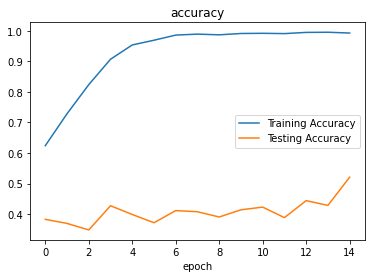

<Figure size 432x288 with 0 Axes>

In [49]:
plot_accuracy(history)

In [0]:
## Summary
## -------
## Resnet50 by considering the attribute "Target"
## Training accuracy: 99.74%
## Validation accuracy: 73.47%
## Recall : 50 %
## Precision : 36.73%
## F1 Score : 42.35%

## Summary
## -------
## Resnet50 by considering the attribute "class"
## Training accuracy: 99.46%
## Validation accuracy: 34.48%
## Recall : 35.68%
## Precision : 47.91%
## F1 Score : 21.11%

In [0]:
# The performance of the model can be improved if the Resnet50 model layers can be made as trainable